# CE-40719: Deep Learning
## HW6 - Deep Reinforcement Learning
(20 points)

#### Name: Seyed Shayan Nazemi
#### Student No.: 98209037


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt


This section is for definition of the environment dynamics function and clasic optimal controller function.

In [2]:
T=0.01
k=0.1
ep=0.01
ep2=0.01

def env(a ,s1,s2):
    next_s1 = s1+T * s2
    next_s2 = s2+T*(-k*s2 +a)
    return next_s1 , next_s2

def optimal_control(s1,s2):
    switching=s1-(np.sign(s2)/(k**2))*np.log(k*(np.abs(s2)+1/k))+(1/k)*s2
    if (switching>ep2):
        a=-1
    elif (switching<-ep2):
        a=1
    elif (switching>-ep2)&(s2>ep)&(switching<ep2):
        a=-1
    elif (switching>-ep2)&(s2<-ep)&(switching<ep2):
        a=1
    else:
        a=0
    return a

## 1. Policy Network Design (4 Points):
Design the layer of your network.

In [3]:
######################################################################
# TODO: Use 'torch.nn' module to design your network for Policy.     #
# In your design you don't have any limitation and you can use       #
# Batch-norm layers, Drop-out layers and etc for generalization      #
# improvement (if needed). Use classes and modules from 'torch.nn'.  #
# In the following code, the 'Policy' class is your policy network.  #
# this class is inherited from nn.Module, so you can benefit         #
# properties of the 'nn.Module'.You may complete '__init__()'        #
# constructor by some classes like 'nn.ReLU()' or 'nn.Linear()'      #
# to use them in the forward pass of your network.                   #
######################################################################

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()

        self.fc1 = nn.Linear(2, 32)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(32, 64)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(64, 2)

    def forward(self, state):

        state = self.act1(self.fc1(state))
        state = self.act2(self.fc2(state))
        state = self.fc3(state)

        return state

## 2. Optimization Algorithm (2 Points):
Select your optimizer and proper hyperparameter.

In [4]:
#############################################################################
# TODO: Use a Cross-Entropy loss.Then, use 'torch.optim' module to optimize #
# Cross-Entropy loss. You should select a optimization algorithm and its    #
# hyperparameters like learning rate and discount factor.                   #
#############################################################################

policy = Policy()
gamma = 0.9
learning_rate = 1e-3
optimizer = optim.Adam(policy.parameters(), lr = learning_rate)


## 3. Training (6 Points):
You can tweak `hidden_dim`, `leanirng_rate`,`num_episodes`and etc to get a high accuracy.

In [ ]:
num_episodes=800
num_max_step=1000

# Episode policy and reward history
policy_history = []
reward_episode = []

# Overall reward and loss history
reward_history = []
loss_history = []

def reward_func(a, s1, s2):
    return 10 - (s1 ** 2 + s2 ** 2 + s1 * s2)

for episode in range(num_episodes):
    state=4*torch.randn(2)
    for step in range(num_max_step):
        action = policy(state)
        action_dist = Categorical(nn.functional.softmax(action))

        sample = action_dist.sample()
        selected_action = 2 * sample - 1

        next_state1,next_state2=env(selected_action, state[0], state[1])
        
        reward = reward_func(selected_action, next_state1, next_state2)

        reward_episode.append(reward)
        policy_history.append(action_dist.log_prob(sample).reshape(1, -1))

    #Calculate discounted reward:
    return_rewards=[]
    discounted_reward = 0
    for reward_ in reward_episode[::-1]:
        discounted_reward = gamma * discounted_reward + reward_
        return_rewards.insert(0,discounted_reward)
    
    return_rewards = torch.FloatTensor(return_rewards)

    # Scale rewards:
    rewards = (return_rewards - return_rewards.mean()) / return_rewards.std()
    
    # Calculate loss
    loss = -torch.sum(torch.mul(torch.cat(policy_history, dim=1).view(-1), rewards))

    # Update network weights:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #Save and intialize episode history counters
    loss_history.append(loss)
    reward_history.append(np.sum(reward_episode)/step)

    print('[Episode %d / %d] reward: %.3f' %
                  (episode, num_episodes, np.sum(reward_episode)/step))
    policy_history = []
    reward_episode= []

 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[Episode 0 / 800] reward: 1.699
[Episode 1 / 800] reward: 6.934
[Episode 2 / 800] reward: 5.898
[Episode 3 / 800] reward: -2.499
[Episode 4 / 800] reward: -20.867
[Episode 5 / 800] reward: 4.195
[Episode 6 / 800] reward: -20.038
[Episode 7 / 800] reward: -5.106
[Episode 8 / 800] reward: -16.812
[Episode 9 / 800] reward: -42.528
[Episode 10 / 800] reward: -6.852
[Episode 11 / 800] reward: 4.525
[Episode 12 / 800] reward: 6.550
[Episode 13 / 800] reward: -9.357
[Episode 14 / 800] reward: 9.839
[Episode 15 / 800] reward: -124.850
[Episode 16 / 800] reward: 0.934
[Episode 17 / 800] reward: -31.221
[Episode 18 / 800] reward: -55.040
[Episode 19 / 800] reward: -22.359
[Episode 20 / 800] reward: -26.899
[Episode 21 / 800] reward: 1.014
[Episode 22 / 800] reward: 0.238
[Episode 23 / 800] reward: -32.512
[Episode 24 / 800] reward: -76.177
[Episode 25 / 800] reward: -18.648
[Episode 26 / 800] reward: -10.070
[Episode 27 / 800] reward: -9.591
[Episode 28 / 800] reward: 9.794
[Episode 29 / 800] re

## 4. Test (8 Points):
You have to get an accuracy above 80% with comparison to the classic optimal control solution.

In [ ]:
correct_predict=0
num=10000
states=4*torch.randn(num,2)
for i in range(num):
    predict_control_tensor=2*torch.argmax(policy(states[i]))-1
    predict_control=predict_control_tensor.item()
    action_optimal_control=optimal_control(states[i,0],states[i,1])
    correct_predict += (predict_control == action_optimal_control)
print('Accuracy: %.3f %%' %(correct_predict/num*100))

Accuracy: 90.300 %


## 5. Visualization:
You can visualize position and velocity of the body that is controlled by policy network with comparison to the classic optimal control solution. 

You can comparise minimum time.

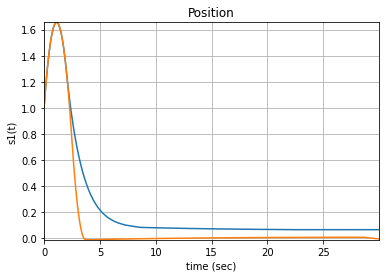

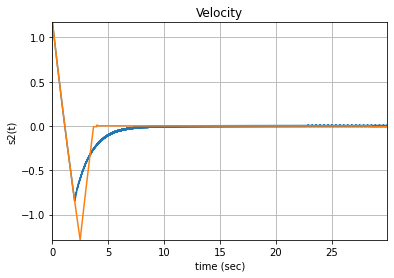

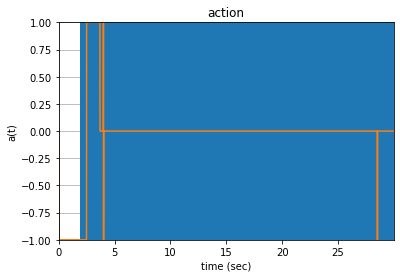

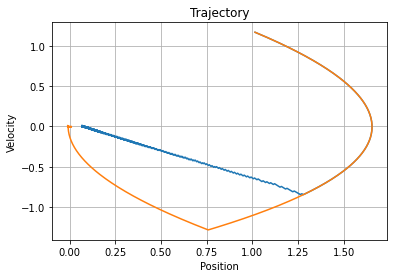

In [ ]:
n=3000
state=4*torch.randn(2)

# print(state)
action_policy=[0]
state1_policy=[state[0].item()]
state2_policy=[state[1].item()]
for t in range(n-1):
    actions=policy(state)
    a_tensor=torch.argmax(actions)
    act=2*a_tensor.item()-1
    next_state1,next_state2=env(act,state[0],state[1])
    state[0]=next_state1
    state[1]=next_state2
    state1_policy.append(next_state1.numpy())
    state2_policy.append(next_state2.numpy())
    action_policy.append(act)

state1_opt=[state1_policy[0]]
state2_opt=[state2_policy[0]]
action_opt=[0]
for t in range(n-1):
    act_optimal=optimal_control(state1_opt[t],state2_opt[t])
    next_state1,next_state2=env(act_optimal,state1_opt[t],state2_opt[t])
    state1_opt.append(next_state1)
    state2_opt.append(next_state2)
    action_opt.append(act_optimal)

time=np.arange(0,n*T,T)
plt.plot(time,state1_policy)
plt.plot(time,state1_opt)
plt.ylabel('s1(t)')
plt.xlabel('time (sec)')
plt.grid(True)
plt.title('Position')
plt.axis([0,np.max(time), np.min([state1_policy,state1_opt]),np.max([state1_policy,state1_opt])])
plt.show()

plt.plot(time,state2_policy)
plt.plot(time,state2_opt)
plt.ylabel('s2(t)')
plt.xlabel('time (sec)')
plt.grid(True)
plt.title('Velocity')
plt.axis([0,np.max(time), np.min([state2_policy,state2_opt]),np.max([state2_policy,state2_opt])])
plt.show()

plt.plot(time,action_policy)
plt.plot(time,action_opt)
plt.ylabel('a(t)')
plt.xlabel('time (sec)')
plt.grid(True)
plt.title('action')
plt.axis([0,np.max(time) , np.min([action_policy,action_opt]),np.max([action_policy,action_opt]) ])
plt.show()

plt.plot(state1_policy,state2_policy)
plt.plot(state1_opt,state2_opt)
plt.ylabel('Velocity')
plt.xlabel('Position')
plt.grid(True)
plt.title('Trajectory')
# plt.axis([np.min(x1),np.max(x1) , np.min(x2),np.max(x2) ])
plt.show()